PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.4     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import h5py

## Import data and add noise

### Cartesian Fourier operator and noise

In [3]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

#u0_mat = (1+0j)*im[ :, 30:206, 160 ]
u0_mat = get_sample_data('2d-mri').data

In [5]:
(n,m) = u0_mat.shape
x = np.linspace(0,m,m,endpoint=False)/m-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

mask = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

# Adding noise
s = 0.15*np.mean(u0_mat)
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+s*np.random.randn(2*n*m).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Creating a random cartesian mask or projecting a radial mask on cartesian grid

In [6]:
x = np.linspace( -0.5, 0.5, m, endpoint = False )
p = np.array([norm.pdf(u,loc=0,scale=0.15) for u in x])
p /= np.sum(p)
y_sampled = np.random.choice( x, size=int(0.5*m), p=p, replace=False)

#Subsampling: From pysap radial mask 
cartesian_p = np.zeros((n*m+1,))
cartesian_p[-1] = 7e-7
for yi in y_sampled:
    j=int((yi+0.5)*n)
    cartesian_p[j*n:(j+1)*n] = np.ones((n,))
#pysap.Image(data=np.reshape(cartesian_p[:-1],(m,n)).transpose()).show()

### Operators

In [7]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=3,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

In [8]:
#ifft on noised data = base result
uk = fourier_op.adj_op(cartesian_p[:-1]*y)
print(ssim(uk,u0_mat))
#pysap.Image(data = np.abs(uk)).show()
#pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

0.9118931200728658


## Reconstruction

In [9]:
# Specific files import
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

In [10]:
param = {"epsilon":1e-3,"gamma":1e-10}

In [11]:
print(g(u0_mat,param["epsilon"]),
      f2(linear_op.op(u0_mat),cartesian_p[-1],param["gamma"]),
      f1(u0_mat,cartesian_p[:-1],y,fourier_op))

1.907348405438831e-09 9.985400438308716e-08 1.8393813345386355e-08


In [12]:
# -- Solving --
p0=cartesian_p
#p0 = np.ones(n**2+1)
p0[-1] = 7e-7

t1 = time.time()
uk,norms,energy,ssims = pdhg(y , p0 ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             ground_truth=u0_mat,
                             const = {"sigma":5,"tau":0.1},
                             maxit=100,
                             compute_energy = True,
                             mask_type="cartesian")
PDHGtime = time.time()-t1

Sigma: 5 
Tau: 0.1


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


10  iterations:
Cost: 9.640048926982538e-08 
Norm: 0.09202625623927069 

20  iterations:
Cost: 9.365161963586017e-08 
Norm: 0.019917891703474147 

30  iterations:
Cost: 9.327900133276522e-08 
Norm: 0.006475548973298102 

40  iterations:
Cost: 9.319145172337109e-08 
Norm: 0.002880062641952426 

50  iterations:
Cost: 9.315991510579188e-08 
Norm: 0.0015467482880965812 

60  iterations:
Cost: 9.31444821068721e-08 
Norm: 0.000977999459177803 

70  iterations:
Cost: 9.313499997085769e-08 
Norm: 0.0007188942869620019 

80  iterations:
Cost: 9.312830439303274e-08 
Norm: 0.0005337097962363148 

90  iterations:
Cost: 9.312312969076152e-08 
Norm: 0.00039106661851493396 

100  iterations:
Cost: 9.311888695420597e-08 
Norm: 0.00031345119210762334 

Finished in 60.93263554573059 seconds.


In [13]:
#Showing
PDHGssim = ssim(u0_mat,uk)
print(PDHGssim)
pysap.Image(data = np.abs(uk)).show()

0.9737627659067382


In [14]:
print(g(uk,param["epsilon"]),
      f2(linear_op.op(uk),cartesian_p[-1],param["gamma"]),
      f1(uk,cartesian_p[:-1],y,fourier_op))

1.8213297511612349e-09 7.073287739095442e-08 2.056467981209032e-08


In [15]:
#pysap.Image(data = np.abs(np.abs(uk)-u0_mat)).show()

In [16]:
#pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()
print(np.std(np.arctan(np.imag(uk)/np.real(uk))))

0.23194790936983026


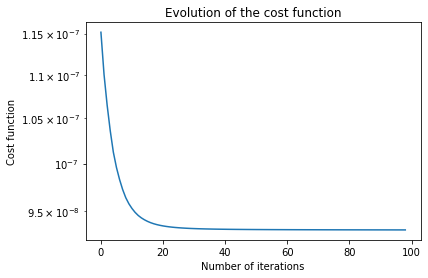

In [17]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Results/PDHG V Condat/PDHG/energy.png")
plt.show()

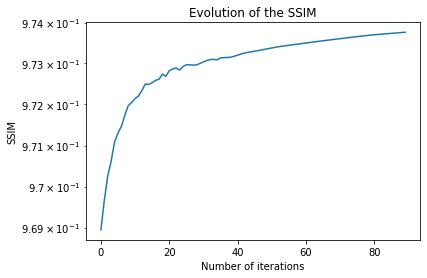

In [18]:
plt.plot(ssims[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Results/PDHG V Condat/PDHG/metrics.png")
plt.show()

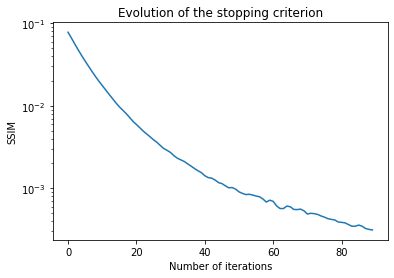

In [19]:
plt.plot(norms[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Results/PDHG V Condat/PDHG/convergence.png")
plt.show()

# Comparison with Condat-Vu

In [20]:
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge,ProximityParent,ProximityCombo

In [21]:
class RegularizerG(ProximityParent):
    r"""L2 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, eps):
        self.weights = [eps]
        self.eps = eps
        self.op = self._op_method
        self.cost = self._cost_method

        
    def _op_method(self, data, extra_factor=1.0):  
        thresh = self.eps*extra_factor
        
        return data/(1+thresh)

    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = self.eps*np.linalg.norm(args[0])**2/2

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - G (X):', cost_val)

        return cost_val

In [22]:
class RegularizerF2(ProximityParent):
    r"""C2 approximation of an L1 norm

    Parameters
    ----------
    linear : class
        Linear operator class
    weights : np.ndarray
        Input array of weights
    """

    def __init__(self, linear, gamma, pn1):
        self.linear = linear
        self.weights = [gamma,pn1]
        self.gamma = gamma
        self.pn1=pn1
        self.op = self._op_method
        self.cost = self._cost_method
    
    def rho(self, x):
        m = np.abs(x)
        return np.where(m<self.gamma,-m**3/3/self.gamma**2+m**2/self.gamma,m-self.gamma/3)    
    
    def prox_J(self,x,c,gamma):
        return np.where(np.abs(x)>gamma+c,x*(1-c/np.abs(x)),
                    gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))

        
    def _op_method(self, data, extra_factor=1.0):  
        return self.prox_J(data,self.pn1*extra_factor,self.gamma)
        
    
    def _cost_method(self, *args, **kwargs):
        
        cost_val = self.pn1*np.sum(self.rho(self.linear.op(args[0])))

        if 'verbose' in kwargs and kwargs['verbose']:
            print(' - F2 (X):', cost_val)

        return cost_val

In [23]:
regularizer_G = RegularizerG(param["epsilon"])
regularizer_F2 = RegularizerF2(linear_op,param["gamma"],cartesian_p[-1])

In [24]:
print(regularizer_G.cost(u0_mat),regularizer_F2.cost(u0_mat))

1.907348405438831e-09 9.985400438308716e-08


In [25]:
from modopt.opt.algorithms import Condat
from mri.operators import GradAnalysis
from modopt.opt.gradient import GradParent,GradBasic

In [26]:
p = cartesian_p[:-1]
gradient_op = GradBasic(p*y,fourier_op.op,fourier_op.adj_op)

In [27]:
metrics = {
        'ssim': {
            'metric': ssim,
            'mapping': {'x_new': 'test', 'y_new': None},
            'cst_kwargs': {'ref': u0_mat, 'mask': None},
            'early_stopping': True,
        },
    }

In [28]:
t2 = time.time()
opt = Condat(x=fourier_op.adj_op(p*y),
    y=p*y,
    grad = gradient_op,
    prox = regularizer_G,
    prox_dual = regularizer_F2,
    linear = linear_op,
    max_iter=100,
    metrics=metrics,
    verbose=0)
CVtime = time.time()-t2

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


 - ITERATION: 1
 - DATA FIDELITY (X): 4.774337970296736e-07
 - G (X): 2.3890760618362624e-09
 - F2 (X): 1.6620899255622375e-07
 - COST: 6.460318656477337e-07



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - ITERATION: 2
 - DATA FIDELITY (X): 4.685889649171697e-07
 - G (X): 2.3525947514764536e-09
 - F2 (X): 1.4572273167596722e-07


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:54

 - COST: 6.166642913446134e-07

 - ITERATION: 3
 - DATA FIDELITY (X): 2.6807492263197817e-07


  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:53

 - G (X): 2.1262453215345334e-09
 - F2 (X): 1.3050689597328568e-07
 - COST: 4.0070806392679836e-07



  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:30

 - ITERATION: 4
 - DATA FIDELITY (X): 1.2718097197422848e-07
 - G (X): 1.965691447487483e-09
 - F2 (X): 1.1660878273566741e-07


  3% (3 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:18

 - COST: 2.457554461573834e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.9532365513220077

 - ITERATION: 5
 - DATA FIDELITY (X): 5.9148265291013286e-08
 - G (X): 1.883915874857772e-09
 - F2 (X): 1.0629206032800217e-07


  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:00:57

 - COST: 1.6732424149387322e-07

 - ITERATION: 6
 - DATA FIDELITY (X): 3.1698712241133524e-08
 - G (X): 1.8471847635795068e-09
 - F2 (X): 9.833053315865009e-08


  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:59

 - COST: 1.3187643016336312e-07

 - ITERATION: 7
 - DATA FIDELITY (X): 2.199782147722222e-08
 - G (X): 1.831309150532324e-09
 - F2 (X): 9.233744200329169e-08


  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.1616657263104624e-07

 - ITERATION: 8
 - DATA FIDELITY (X): 1.911189592522635e-08
 - G (X): 1.8243088553075516e-09
 - F2 (X): 8.774739822034822e-08


  7% (7 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:00:55

 - COST: 1.0868360300088212e-07

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.3306668354443142

 - ITERATION: 9
 - DATA FIDELITY (X): 1.8609648175000325e-08
 - G (X): 1.821036138304352e-09
 - F2 (X): 8.42080846450892e-08


  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:00:54

 - COST: 1.0463876895839387e-07

 - ITERATION: 10
 - DATA FIDELITY (X): 1.8857219725082217e-08
 - G (X): 1.8193855215379905e-09
 - F2 (X): 8.144597858903492e-08


  9% (9 of 100) |##                      | Elapsed Time: 0:00:05 ETA:   0:00:53

 - COST: 1.0212258383565513e-07

 - ITERATION: 11
 - DATA FIDELITY (X): 1.9292846521971874e-08
 - G (X): 1.8184935659632018e-09
 - F2 (X): 7.92743660021275e-08


 10% (10 of 100) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:53

 - COST: 1.0038570609006258e-07

 - ITERATION: 12
 - DATA FIDELITY (X): 1.9734802926689455e-08
 - G (X): 1.8179860496589884e-09
 - F2 (X): 7.755671294741764e-08


 11% (11 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 9.910950192376608e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.03642265321840042

 - ITERATION: 13
 - DATA FIDELITY (X): 2.0130325068308608e-08
 - G (X): 1.8176876550510434e-09
 - F2 (X): 7.61927302096656e-08


 12% (12 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:00:52

 - COST: 9.814074293302525e-08

 - ITERATION: 14
 - DATA FIDELITY (X): 2.046828642008981e-08
 - G (X): 1.8175083478344285e-09
 - F2 (X): 7.510593209863721e-08


 13% (13 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:00:51

 - COST: 9.739172686656145e-08

 - ITERATION: 15
 - DATA FIDELITY (X): 2.0751192938666153e-08
 - G (X): 1.817399061423745e-09
 - F2 (X): 7.423773160688233e-08


 14% (14 of 100) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:50

 - COST: 9.680632360697224e-08

 - ITERATION: 16
 - DATA FIDELITY (X): 2.0985395923352683e-08
 - G (X): 1.8173316764208462e-09
 - F2 (X): 7.354259224573588e-08


 15% (15 of 100) |###                    | Elapsed Time: 0:00:09 ETA:   0:00:50

 - COST: 9.634531984550941e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.012326202897107494

 - ITERATION: 17
 - DATA FIDELITY (X): 2.117807497328722e-08
 - G (X): 1.8172897819339171e-09
 - F2 (X): 7.298505528481626e-08


 16% (16 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 9.59804200400374e-08

 - ITERATION: 18
 - DATA FIDELITY (X): 2.133592197905013e-08
 - G (X): 1.8172635506332494e-09
 - F2 (X): 7.253724120122762e-08


 17% (17 of 100) |###                    | Elapsed Time: 0:00:10 ETA:   0:00:49

 - COST: 9.569042673091099e-08

 - ITERATION: 19
 - DATA FIDELITY (X): 2.1464857110135907e-08
 - G (X): 1.8172470396161427e-09
 - F2 (X): 7.217714804024787e-08


 18% (18 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 9.545925218999993e-08

 - ITERATION: 20
 - DATA FIDELITY (X): 2.1569943620005055e-08
 - G (X): 1.8172365887059931e-09
 - F2 (X): 7.18872975596863e-08


 19% (19 of 100) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:47

 - COST: 9.527447776839735e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.004913220187931698

 - ITERATION: 21
 - DATA FIDELITY (X): 2.1655452360890344e-08
 - G (X): 1.8172299418076412e-09
 - F2 (X): 7.16537893324741e-08


 20% (20 of 100) |####                   | Elapsed Time: 0:00:12 ETA:   0:00:47

 - COST: 9.512647163517209e-08

 - ITERATION: 22
 - DATA FIDELITY (X): 2.1724946369109212e-08
 - G (X): 1.8172256954541307e-09
 - F2 (X): 7.146553290740434e-08


 21% (21 of 100) |####                   | Elapsed Time: 0:00:13 ETA:   0:00:46

 - COST: 9.500770497196768e-08

 - ITERATION: 23
 - DATA FIDELITY (X): 2.178137096034624e-08
 - G (X): 1.8172229721051164e-09
 - F2 (X): 7.131366738578961e-08


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:48

 - COST: 9.491226131824096e-08

 - ITERATION: 24
 - DATA FIDELITY (X): 2.182714940765781e-08
 - G (X): 1.817221219588212e-09
 - F2 (X): 7.119109705941964e-08


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:46

 - COST: 9.483546768666566e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0020366388797367256

 - ITERATION: 25
 - DATA FIDELITY (X): 2.1864268128293555e-08
 - G (X): 1.8172200884904262e-09
 - F2 (X): 7.109213020033268e-08


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:14 ETA:   0:00:45

 - COST: 9.477361841711667e-08

 - ITERATION: 26
 - DATA FIDELITY (X): 2.189435151493333e-08
 - G (X): 1.8172193565692789e-09
 - F2 (X): 7.101219395190963e-08


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:15 ETA:   0:00:45

 - COST: 9.472376482341223e-08

 - ITERATION: 27
 - DATA FIDELITY (X): 2.191872456958916e-08
 - G (X): 1.8172188818806884e-09
 - F2 (X): 7.094761037046223e-08


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:00:49

 - COST: 9.468355382193207e-08

 - ITERATION: 28
 - DATA FIDELITY (X): 2.1938465331472947e-08
 - G (X): 1.8172185734330852e-09
 - F2 (X): 7.089541920636147e-08


 27% (27 of 100) |######                 | Elapsed Time: 0:00:16 ETA:   0:00:48

 - COST: 9.46511031112675e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0008594639246989993

 - ITERATION: 29
 - DATA FIDELITY (X): 2.1954450107243547e-08
 - G (X): 1.8172183726659155e-09
 - F2 (X): 7.085323550166729e-08


 28% (28 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:43

 - COST: 9.462490398157675e-08

 - ITERATION: 30
 - DATA FIDELITY (X): 2.1967391127744926e-08
 - G (X): 1.8172182417858253e-09
 - F2 (X): 7.081913589808592e-08


 28% (29 of 100) |######                 | Elapsed Time: 0:00:17 ETA:   0:00:42

 - COST: 9.460374526761666e-08

 - ITERATION: 31
 - DATA FIDELITY (X): 2.1977866086894056e-08
 - G (X): 1.8172181563464114e-09
 - F2 (X): 7.079156914539278e-08


 30% (30 of 100) |######                 | Elapsed Time: 0:00:18 ETA:   0:00:41

 - COST: 9.458665338863326e-08

 - ITERATION: 32
 - DATA FIDELITY (X): 2.1986344056255597e-08
 - G (X): 1.8172181004945714e-09
 - F2 (X): 7.07692829738683e-08


 31% (31 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:41

 - COST: 9.457284513061847e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.0003655683721040101

 - ITERATION: 33
 - DATA FIDELITY (X): 2.1993205349607872e-08
 - G (X): 1.8172180639346669e-09
 - F2 (X): 7.075126660190878e-08


 32% (32 of 100) |#######                | Elapsed Time: 0:00:19 ETA:   0:00:40

 - COST: 9.456169001545132e-08

 - ITERATION: 34
 - DATA FIDELITY (X): 2.199875802228839e-08
 - G (X): 1.8172180399701227e-09
 - F2 (X): 7.073670435598612e-08


 33% (33 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:40

 - COST: 9.455268041824464e-08

 - ITERATION: 35
 - DATA FIDELITY (X): 2.2003251534856108e-08
 - G (X): 1.8172180242389041e-09
 - F2 (X): 7.072493806037915e-08


 34% (34 of 100) |#######                | Elapsed Time: 0:00:20 ETA:   0:00:38

 - COST: 9.454540761947416e-08

 - ITERATION: 36
 - DATA FIDELITY (X): 2.200688779666812e-08
 - G (X): 1.8172180138960545e-09
 - F2 (X): 7.071543677947952e-08


 36% (36 of 100) |########               | Elapsed Time: 0:00:21 ETA:   0:00:28

 - COST: 9.453954259004368e-08

 - CONVERGENCE TEST - 
 - CHANGE IN COST: 0.00015559262725836924



100% (100 of 100) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


In [29]:
uk = opt.x_final
CVssim = ssim(uk,u0_mat)
print(CVssim)
#pysap.Image(data = uk).show()

0.9700318579436361


In [30]:
#pysap.Image(data=np.abs(uk-u0_mat)).show()

Text(0, 0.5, 'SSIM')

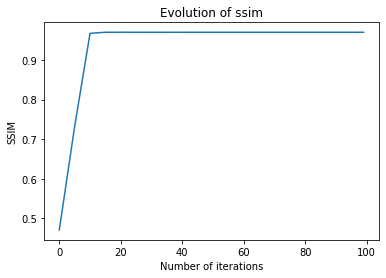

In [31]:
plt.plot(opt.metrics['ssim']['index'],opt.metrics['ssim']['values'])
plt.title("Evolution of ssim")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
#plt.savefig("Results/PDHG V Condat/Condat/ssim.png")

In [32]:
print(f"Condat-Vu converged in {CVtime}s for a final SSIM of {CVssim}",
f"\nPDHG converged in {PDHGtime} for a final ssim of {PDHGssim}")

Condat-Vu converged in 50.07612633705139s for a final SSIM of 0.9700318579436361 
PDHG converged in 61.207974910736084 for a final ssim of 0.9737627659067382
